1. To avoid curse of dimensionality, we think select part of columns is better than use all parameters
2. compare knn and linear regress

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [7]:
student_data <- read_delim(file = "https://raw.githubusercontent.com/czhang176/dsci100_groupproject/main/student-mat.csv", delim = ";") 
student_data

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,4,3,4,1,1,3,6,5,6,6
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,5,3,3,1,1,3,4,5,5,6
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,4,3,2,2,3,3,10,7,8,10
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
MS,M,21,R,GT3,T,1,1,other,other,⋯,5,5,3,3,3,3,3,10,8,7
MS,M,18,R,LE3,T,3,2,services,other,⋯,4,4,1,3,4,5,0,11,12,10
MS,M,19,U,LE3,T,1,1,other,at_home,⋯,3,2,3,3,3,5,5,8,9,9


## find the best columns

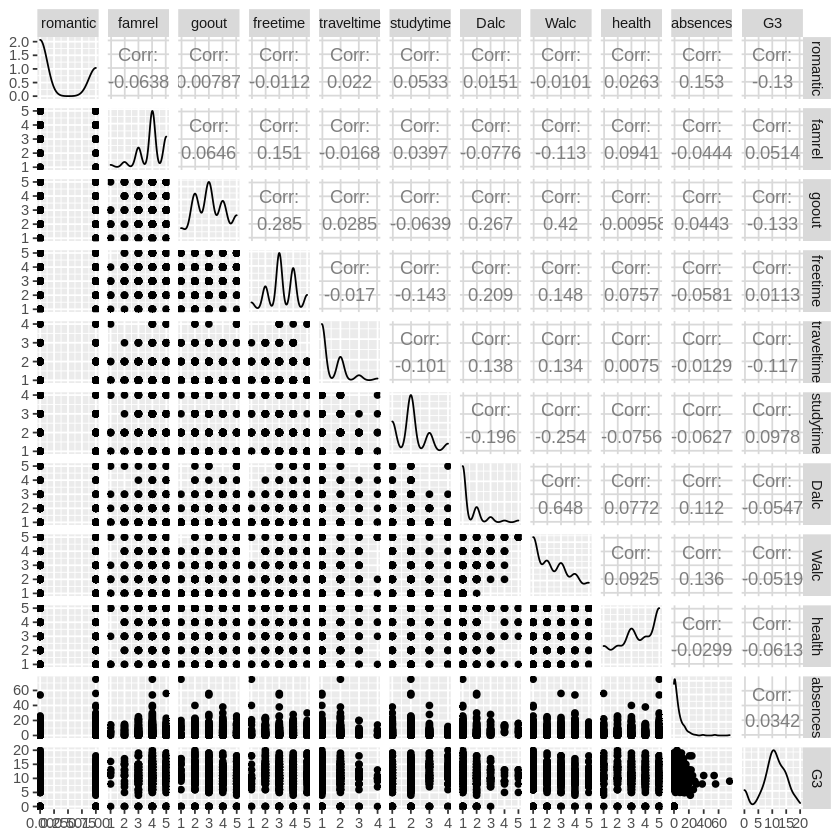

In [3]:
plot_pairs <- student_data %>% mutate(romantic = nchar(romantic)-2) %>%
  select(romantic, famrel, goout, freetime, traveltime,studytime,Dalc,Walc,health,absences,G3) %>%
  ggpairs()
plot_pairs

1. goout, romantic, traveltime have closer relationship with G3.
2. relationships(goout, romantic,famrel) have a bigger influence than time arrangement(traveltime, studytime,freetime) in G3. 
3. I have compare the result of using goout, romantic, traveltime separately, and I find that using only goout and romantic have smallest rmse than using only  goout or all of these three.

In [4]:
set.seed(1)
# select the lines we want
student_data <- student_data %>% 
                            select(goout, romantic, traveltime,G3) %>% 
                            mutate(romantic = nchar(romantic)-2)%>%  # assign classifier (final grade) as factor, change 'yes/no' to numeric value
                            select(goout, romantic,G3)

## knn Regression

In [8]:
# knn start
# 1. Create the train / test split and Cross-validation data set
student_split <- initial_split(student_data, prop = 0.75, strata = G3)  
student_train <- training(student_split)   
student_test <- testing(student_split)
# 1.2 Create Cross-validation data set
student_vfold <- vfold_cv(student_train, v = 5, strata = G3)

# 2. Pre-process the data
student_recipe <- recipe(G3 ~ ., data = student_train) %>% 
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

# 3. Train the classifier
# 3.1 create the KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

# 3.2 train
gridvals <- tibble(neighbors = seq(1, 100))
student_knn_fit <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = student_vfold, grid = gridvals)

student_knn_result = student_knn_fit %>% collect_metrics()
student_knn_result

# 4. show only the row of minimum RMSPE
student_knn_min <- student_knn_result %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
student_knn_min

x Fold1: recipe: Error: All columns selected for the step should be numeric

x Fold2: recipe: Error: All columns selected for the step should be numeric

x Fold3: recipe: Error: All columns selected for the step should be numeric

x Fold4: recipe: Error: All columns selected for the step should be numeric

x Fold5: recipe: Error: All columns selected for the step should be numeric

Warning message:
“All models failed in tune_grid(). See the `.notes` column.”


ERROR: Error: All of the models failed. See the .notes column.


## Linear Regression

In [9]:
student_lm_recipe <- recipe(G3 ~ ., data = student_train)

lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

# 3. train
student_lm_fit <- workflow() %>%
  add_recipe(student_lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = student_train)
student_lm_fit

# 4. Predict the labels in the test set 
student_lm_test_results <- predict(student_lm_fit, student_test) %>%
  bind_cols(student_test)  
student_lm_test_results

# 5. Compute the accuracy
student_lm_test_accuracy = student_lm_test_results %>%
  metrics(truth = G3, estimate = .pred)
student_lm_test_accuracy


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
     (Intercept)          schoolMS              sexM               age  
       -2.323239          0.660764          0.247088         -0.112625  
        addressU        famsizeLE3          PstatusT              Medu  
        0.004916          0.083193         -0.269769          0.093128  
            Fedu        Mjobhealth         Mjobother      Mjobservices  
       -0.110467         -0.362698         -0.084579         -0.253192  
     Mjobteacher        Fjobhealth         Fjobother      Fjobservices  
       -0.121497          0.272856         -0.102204         -0.379562  
     Fjobteacher        reasonhome       reasonothe

.pred,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,⋯,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.103487,GP,F,15,U,LE3,T,1,1,at_home,⋯,4,3,2,2,3,3,10,7,8,10
12.765338,GP,F,15,U,GT3,T,4,2,health,⋯,3,2,2,1,1,5,2,15,14,15
18.542011,GP,M,15,U,LE3,A,3,2,services,⋯,4,2,2,1,1,1,0,16,18,19
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
16.362840,MS,M,17,U,LE3,T,3,1,services,⋯,2,4,5,3,4,2,3,14,16,16
7.811581,MS,M,21,R,GT3,T,1,1,other,⋯,5,5,3,3,3,3,3,10,8,7
13.100318,MS,M,18,R,LE3,T,3,2,services,⋯,4,4,1,3,4,5,0,11,12,10


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.8746781
rsq,standard,0.8474701
mae,standard,1.2797765


So knn regression have smaller rmse.